Import packages.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
color = sns.color_palette()
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

/Users/angieli/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


EDA about player and salary.

In [2]:
salary_df = pd.read_csv("nba_2017_salary.csv");
salary_df.sort_values('SALARY',ascending=False)[:10]

,NAME,POSITION,TEAM,SALARY
0,LeBron James,SF,Cleveland Cavaliers,30963450.0
1,Mike Conley,PG,Memphis Grizzlies,26540100.0
2,Al Horford,C,Boston Celtics,26540100.0
447,James Harden,PG,Houston Rockets,26500000.0
446,Kevin Durant,SF,Golden State Warriors,26500000.0
448,Russell Westbrook,PG,Oklahoma City Thunder,26500000.0
3,Dirk Nowitzki,PF,Dallas Mavericks,25000000.0
4,Carmelo Anthony,SF,New York Knicks,24559380.0
5,Damian Lillard,PG,Portland Trail Blazers,24328425.0
6,Chris Bosh,PF,Miami Heat,23741060.0


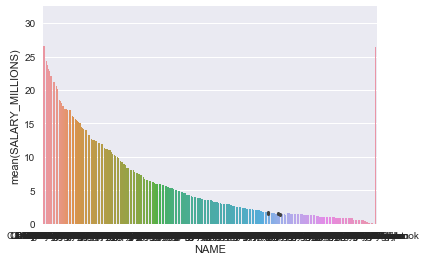

In [3]:
#round salary to millions for easier to read, plot bar chart
salary_df["SALARY_MILLIONS"] = round(salary_df["SALARY"]/1000000, 2)
sns.barplot(x='NAME', y='SALARY_MILLIONS', data=salary_df)

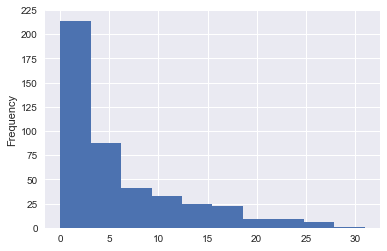

In [4]:
#distribution of salary
salary_df['SALARY_MILLIONS'].plot(kind='hist')

EDA about player and twitter.

In [5]:
twitter_df = pd.read_csv("nba_2017_twitter_players.csv");
twitter_df.head()

,PLAYER,TWITTER_FAVORITE_COUNT,TWITTER_RETWEET_COUNT
0,Russell Westbrook,2130.5,559.0
1,James Harden,969.0,321.5
2,Isaiah Thomas,467.5,155.5
3,Anthony Davis,368.0,104.0
4,DeMar DeRozan,0.0,186.0


In [6]:
#Merge twitter table to play&salary table
salary_df.rename(columns={'NAME': 'PLAYER',}, inplace=True)
salary_twit_df=salary_df.merge(twitter_df);
salary_twit_df.head()


,PLAYER,POSITION,TEAM,SALARY,SALARY_MILLIONS,TWITTER_FAVORITE_COUNT,TWITTER_RETWEET_COUNT
0,LeBron James,SF,Cleveland Cavaliers,30963450.0,30.96,5533.5,1501.5
1,Mike Conley,PG,Memphis Grizzlies,26540100.0,26.54,257.5,90.0
2,Al Horford,C,Boston Celtics,26540100.0,26.54,136.0,71.0
3,Dirk Nowitzki,PF,Dallas Mavericks,25000000.0,25.00,1564.0,500.5
4,Carmelo Anthony,SF,New York Knicks,24559380.0,24.56,720.5,220.0


In [7]:
#Combinte twitter favorite and retweet
salary_twit_df['TOTAL_TWIT']=salary_twit_df['TWITTER_FAVORITE_COUNT']+salary_twit_df['TWITTER_RETWEET_COUNT'];
salary_twit_df.head()

,PLAYER,POSITION,TEAM,SALARY,SALARY_MILLIONS,TWITTER_FAVORITE_COUNT,TWITTER_RETWEET_COUNT,TOTAL_TWIT
0,LeBron James,SF,Cleveland Cavaliers,30963450.0,30.96,5533.5,1501.5,7035.0
1,Mike Conley,PG,Memphis Grizzlies,26540100.0,26.54,257.5,90.0,347.5
2,Al Horford,C,Boston Celtics,26540100.0,26.54,136.0,71.0,207.0
3,Dirk Nowitzki,PF,Dallas Mavericks,25000000.0,25.00,1564.0,500.5,2064.5
4,Carmelo Anthony,SF,New York Knicks,24559380.0,24.56,720.5,220.0,940.5


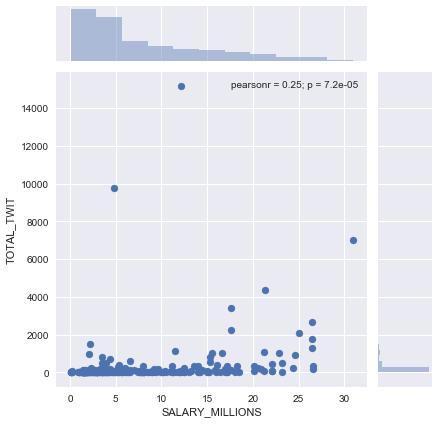

In [8]:
#Check relationship between total twit and salary
sns.jointplot(x="SALARY_MILLIONS", y="TOTAL_TWIT", data=salary_twit_df)

Check win rate for players.

In [9]:
plus_minus_df = pd.read_csv("nba_2017_real_plus_minus.csv");plus_minus_df.head()

,NAME,TEAM,GP,MPG,ORPM,DRPM,RPM,WINS
0,"LeBron James, SF",CLE,74,37.8,6.49,1.93,8.42,20.43
1,"Stephen Curry, PG",GS,79,33.4,7.27,0.14,7.41,18.80
2,"Jimmy Butler, SG",CHI,76,37.0,4.82,1.80,6.62,17.35
3,"Russell Westbrook, PG",OKC,81,34.6,6.74,-0.47,6.27,17.34
4,"Draymond Green, PF",GS,76,32.5,1.55,5.59,7.14,16.84


In [10]:
#split and rename colomns
plus_minus_df.rename(columns={"NAME":"PLAYER", "WINS": "WINS_RPM"}, inplace=True)
players = []
for player in plus_minus_df["PLAYER"]:
    plyr, _ = player.split(",")
    players.append(plyr)
plus_minus_df.drop(["PLAYER"], inplace=True, axis=1)
plus_minus_df["PLAYER"] = players
plus_minus_df.head()

,TEAM,GP,MPG,ORPM,DRPM,RPM,WINS_RPM,PLAYER
0,CLE,74,37.8,6.49,1.93,8.42,20.43,LeBron James
1,GS,79,33.4,7.27,0.14,7.41,18.80,Stephen Curry
2,CHI,76,37.0,4.82,1.80,6.62,17.35,Jimmy Butler
3,OKC,81,34.6,6.74,-0.47,6.27,17.34,Russell Westbrook
4,GS,76,32.5,1.55,5.59,7.14,16.84,Draymond Green


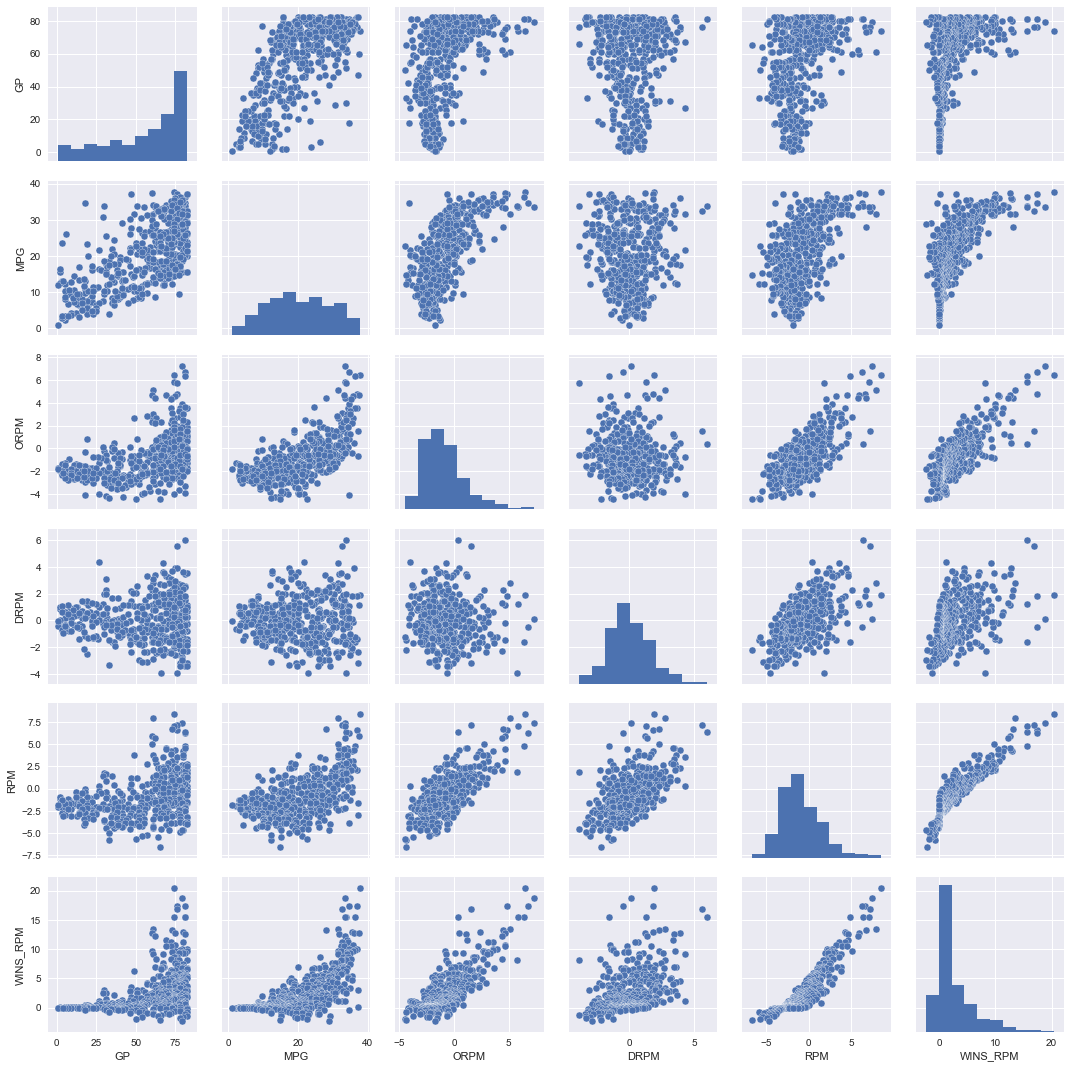

In [11]:
#plot pairplot
sns.pairplot(plus_minus_df)

In [12]:
#merge win info with player&salary&twit
nba_players_df=salary_twit_df.merge(plus_minus_df,on="PLAYER",how="inner");
nba_players_df.head()

,PLAYER,POSITION,TEAM_x,SALARY,SALARY_MILLIONS,TWITTER_FAVORITE_COUNT,TWITTER_RETWEET_COUNT,TOTAL_TWIT,TEAM_y,GP,MPG,ORPM,DRPM,RPM,WINS_RPM
0,LeBron James,SF,Cleveland Cavaliers,30963450.0,30.96,5533.5,1501.5,7035.0,CLE,74,37.8,6.49,1.93,8.42,20.43
1,Mike Conley,PG,Memphis Grizzlies,26540100.0,26.54,257.5,90.0,347.5,MEM,69,33.2,4.67,-0.20,4.47,10.50
2,Al Horford,C,Boston Celtics,26540100.0,26.54,136.0,71.0,207.0,BOS,68,32.3,0.76,1.06,1.82,6.93
3,Dirk Nowitzki,PF,Dallas Mavericks,25000000.0,25.00,1564.0,500.5,2064.5,DAL,54,26.4,-0.38,0.64,0.26,3.02
4,Carmelo Anthony,SF,New York Knicks,24559380.0,24.56,720.5,220.0,940.5,NY,74,34.3,1.87,-1.75,0.12,5.26


In [13]:
nba_players_df.drop(["TEAM_y"], inplace=True, axis=1);
nba_players_df.rename(columns={"TEAM_x":"TEAM"}, inplace=True)
nba_players_df.head()

,PLAYER,POSITION,TEAM,SALARY,SALARY_MILLIONS,TWITTER_FAVORITE_COUNT,TWITTER_RETWEET_COUNT,TOTAL_TWIT,GP,MPG,ORPM,DRPM,RPM,WINS_RPM
0,LeBron James,SF,Cleveland Cavaliers,30963450.0,30.96,5533.5,1501.5,7035.0,74,37.8,6.49,1.93,8.42,20.43
1,Mike Conley,PG,Memphis Grizzlies,26540100.0,26.54,257.5,90.0,347.5,69,33.2,4.67,-0.20,4.47,10.50
2,Al Horford,C,Boston Celtics,26540100.0,26.54,136.0,71.0,207.0,68,32.3,0.76,1.06,1.82,6.93
3,Dirk Nowitzki,PF,Dallas Mavericks,25000000.0,25.00,1564.0,500.5,2064.5,54,26.4,-0.38,0.64,0.26,3.02
4,Carmelo Anthony,SF,New York Knicks,24559380.0,24.56,720.5,220.0,940.5,74,34.3,1.87,-1.75,0.12,5.26


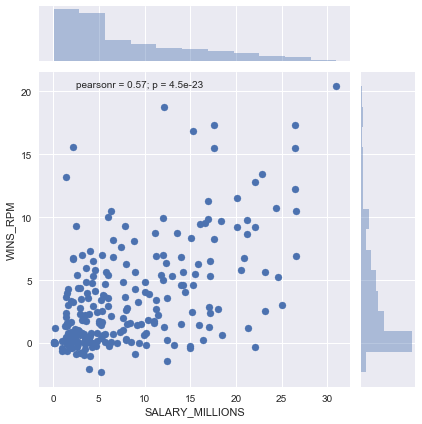

In [14]:
#check relationship between salary and wins
p1=sns.jointplot(x="SALARY_MILLIONS", y="WINS_RPM", data=nba_players_df)

In [15]:
#merge player info with salary
nba_players_with_salary_df = nba_players_df.merge(salary_df); 

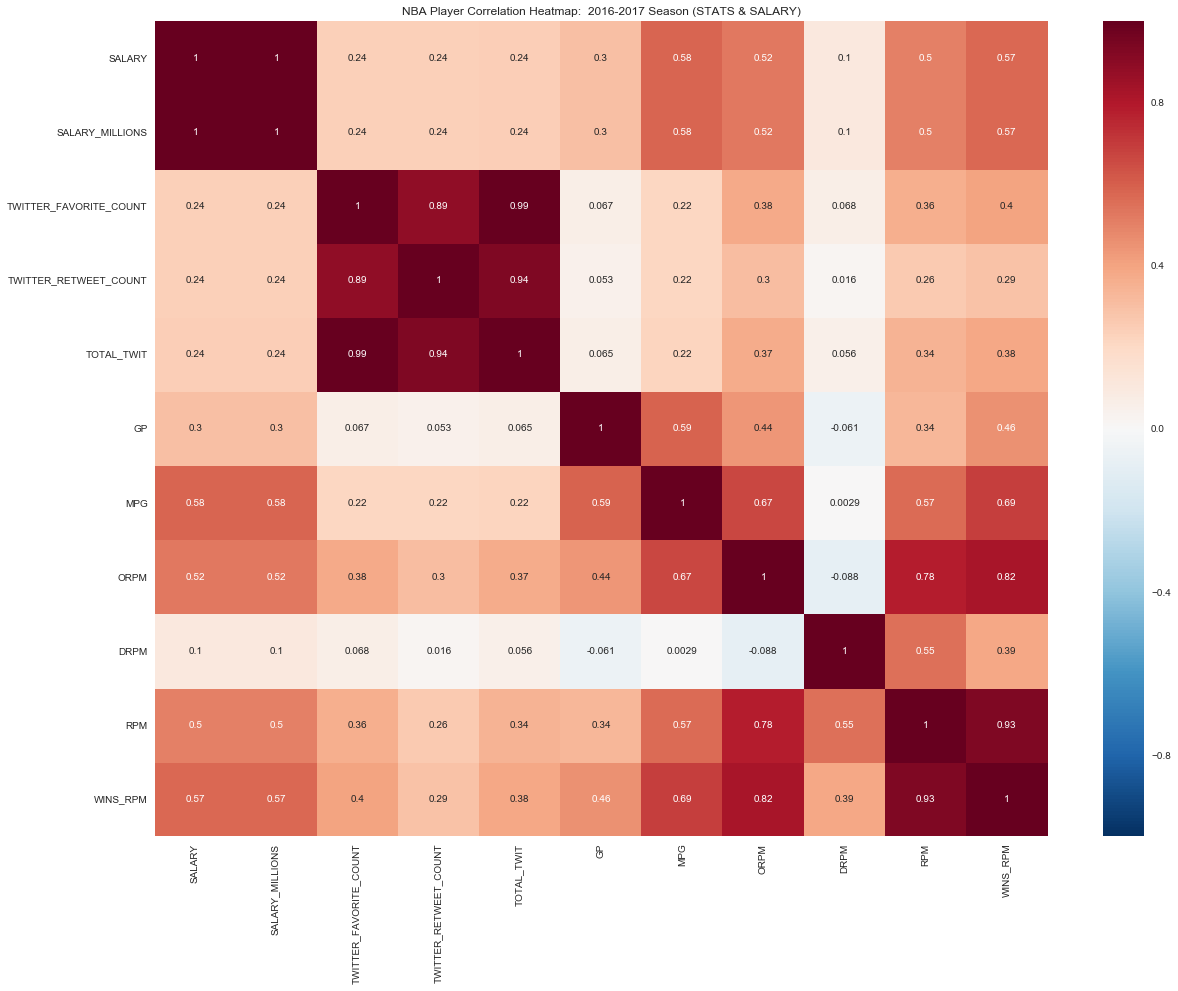

In [16]:
#plot correlation heatmap 
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("NBA Player Correlation Heatmap:  2016-2017 Season (STATS & SALARY)")
corr = nba_players_df.corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [17]:
#check regression for wins_rpm and salary
results = smf.ols('SALARY_MILLIONS ~WINS_RPM', data=nba_players_df).fit();
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        SALARY_MILLIONS   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     120.3
Date:                Thu, 18 Jan 2018   Prob (F-statistic):           4.51e-23
Time:                        21:51:15   Log-Likelihood:                -787.23
No. Observations:                 250   AIC:                             1578.
Df Residuals:                     248   BIC:                             1585.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7386      0.462     10.255      0.0

In [18]:
#check regression for wins_rpm and salary
results = smf.ols('TOTAL_TWIT ~WINS_RPM', data=nba_players_df).fit();
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             TOTAL_TWIT   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     42.18
Date:                Thu, 18 Jan 2018   Prob (F-statistic):           4.59e-10
Time:                        21:51:15   Log-Likelihood:                -2102.1
No. Observations:                 247   AIC:                             4208.
Df Residuals:                     245   BIC:                             4215.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -90.5666     99.425     -0.911      0.3

In my opinion, through visualizations and regression results, it seems like the social power (twitter in this case) of the players doesn't really have more correlation than salary with win rate. Maybe using other regression models will have different results.